## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

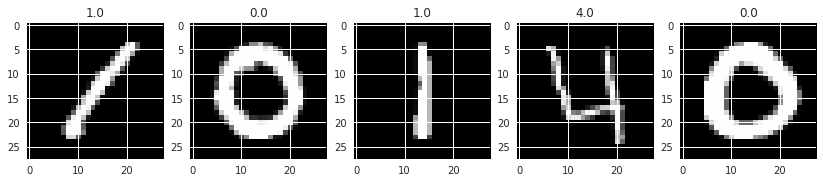

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

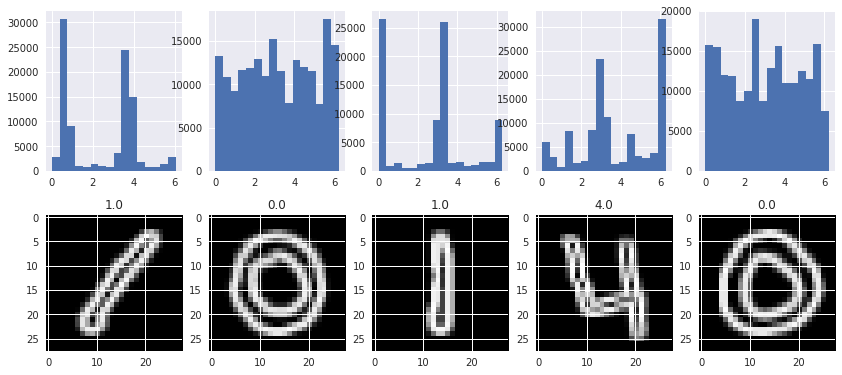

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [16]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [17]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центроид для валидации

In [18]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.34      0.12      0.18       816
        1.0       0.59      0.76      0.66       909
        2.0       0.33      0.29      0.31       846
        3.0       0.55      0.49      0.51       937
        4.0       0.33      0.31      0.32       839
        5.0       0.46      0.67      0.55       702
        6.0       0.24      0.45      0.31       785
        7.0       0.73      0.41      0.53       893
        8.0       0.39      0.49      0.44       835
        9.0       0.48      0.27      0.34       838

avg / total       0.45      0.43      0.42      8400



In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    else:
    #    print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

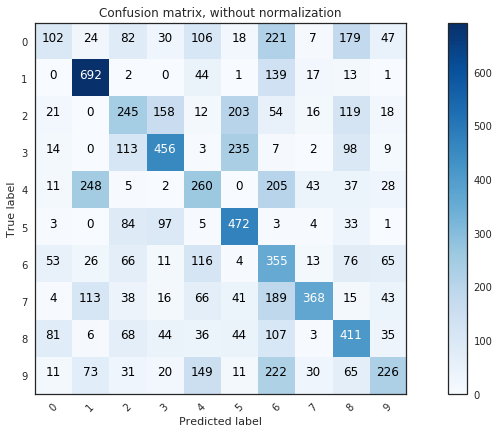

In [24]:
# Compute confusion matrix
sns.set_style("white")
import itertools
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(y_val, pred_val)
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,6))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Confusion matrix, without normalization')
plt.show();

## Предсказания на тестовыйх данных

In [25]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

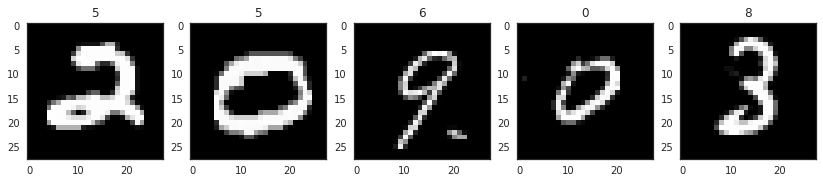

In [26]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [27]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [28]:
!head submit.txt

ImageId,Label
1,5
2,5
3,6
4,0
5,8
6,7
7,6
8,3
9,8


In [29]:
# Your submission scored 0.41700

### Попробуем другие модели на гистограммах

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [31]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()]

names = [
    'Метод ближайших соседей',
    'Метод опорных векторов (c=0.025)', 
    'Метод опорных векторов (c=1)',
    'Рещающее дерево (max_depth=5)',
    'Случайное дерево(max_depth=5)',
    'Adaptive Bosting',
]

In [38]:
def get_accuracies(classifiers, names, X_train, X_test, y_train, y_test):
    
    accuracies = []
    for clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        
    return accuracies

In [39]:
accuracies = get_accuracies(classifiers, names, x_train, x_val, y_train, y_val)

In [41]:
dict(zip(names, accuracies))

{'Adaptive Bosting': 0.4380952380952381,
 'Метод ближайших соседей': 0.5576190476190476,
 'Метод опорных векторов (c=0.025)': 0.5514285714285714,
 'Метод опорных векторов (c=1)': 0.6502380952380953,
 'Рещающее дерево (max_depth=5)': 0.42892857142857144,
 'Случайное дерево(max_depth=5)': 0.5061904761904762}

### Выбирем лучшую модель и применем к тестовой выборке

In [42]:
clf = classifiers[accuracies.index(max(accuracies))]
clf.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
y_pred = clf.predict(x_val)

In [50]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

        0.0       0.44      0.43      0.44       816
        1.0       0.97      0.95      0.96       909
        2.0       0.50      0.46      0.48       846
        3.0       0.66      0.71      0.68       937
        4.0       0.72      0.71      0.72       839
        5.0       0.62      0.66      0.64       702
        6.0       0.48      0.46      0.47       785
        7.0       0.87      0.79      0.83       893
        8.0       0.52      0.59      0.56       835
        9.0       0.68      0.68      0.68       838

avg / total       0.65      0.65      0.65      8400



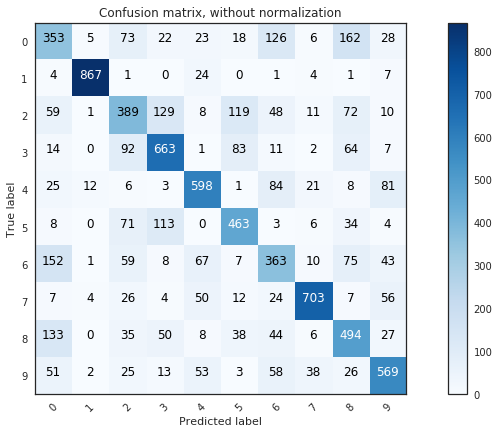

In [49]:
cnf_matrix = confusion_matrix(y_val, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,6))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Confusion matrix, without normalization')
plt.show();

In [43]:
pred_test = clf.predict(test_hist).astype(int)

In [51]:
with open('submit_1.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [113]:
# Your submission scored 0.65457

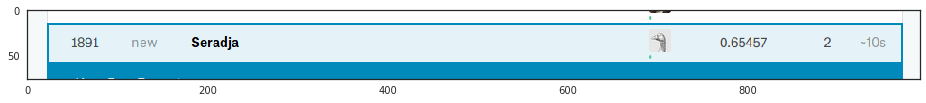

In [52]:
import matplotlib.image as mpimg
img = mpimg.imread('Kaggle_1.png')
plt.figure(figsize=(16, 4))
imgplot = plt.imshow(img)
plt.show();

### PCA

In [53]:
from sklearn.decomposition import PCA

In [54]:
X = train[:, 1:]
y = train[:, 0]

In [55]:
pca = PCA()

In [56]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

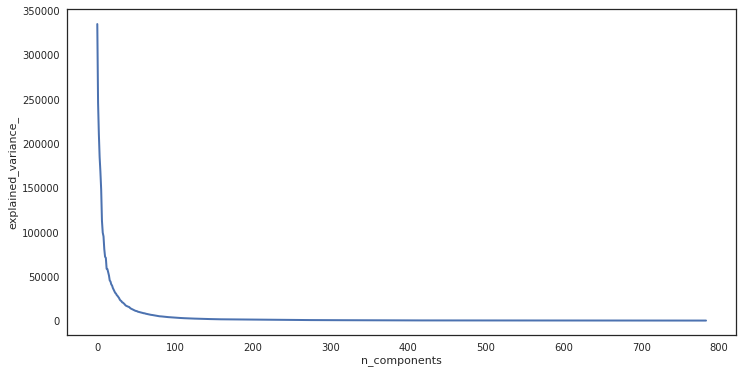

In [57]:
sns.set()
plt.figure(figsize=(12, 6))
plt.plot(pca.explained_variance_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

### Оставим 100 компонент. 
По графику видно, что 100 компонент объясняют довольно большое количество информации.

In [58]:
pca.n_components=100

In [59]:
pca

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [60]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [61]:
X_train_pca = pca.transform(X)
X_test_pca = pca.transform(test)

In [88]:
from sklearn.preprocessing import StandardScaler

StandardScaler(copy=True, with_mean=True, with_std=True)


In [91]:
scaler.fit(X_train_pca)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [92]:
X_train_pca = scaler.fit_transform(X_train_pca)

In [104]:
X_test_pca = scaler.fit_transform(X_test_pca)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_train_pca, y, test_size=0.2, random_state=42)

In [97]:
clf = SVC(C=1)

In [98]:
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [99]:
y_pred = clf.predict(X_test)

In [100]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       816
        1.0       0.99      0.99      0.99       909
        2.0       0.98      0.97      0.97       846
        3.0       0.97      0.96      0.97       937
        4.0       0.97      0.98      0.97       839
        5.0       0.97      0.97      0.97       702
        6.0       0.98      0.99      0.98       785
        7.0       0.98      0.97      0.98       893
        8.0       0.96      0.98      0.97       835
        9.0       0.97      0.97      0.97       838

avg / total       0.98      0.98      0.98      8400



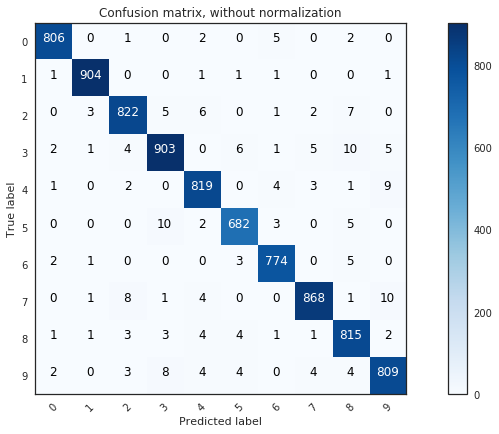

In [102]:
cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,6))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Confusion matrix, without normalization')
plt.show();

In [105]:
scaler.fit(X_test_pca)
X_test_pca = scaler.fit_transform(X_test_pca)

In [106]:
pred_test = clf.predict(X_test_pca).astype(int)

In [107]:
with open('submit_2.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

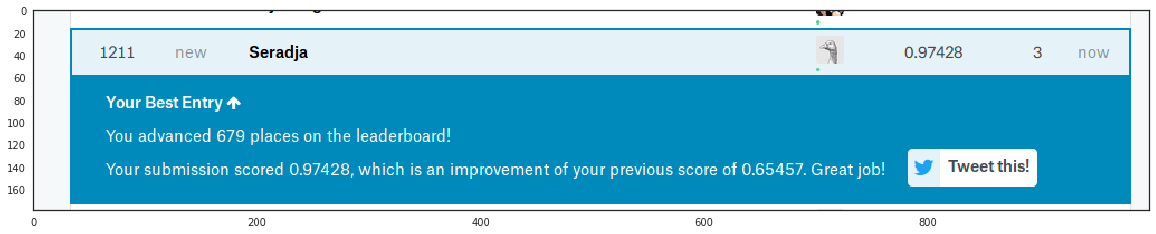

In [112]:
img = mpimg.imread('Kaggle_2.png')
plt.figure(figsize=(20, 6))
imgplot = plt.imshow(img)
plt.show();

In [114]:
# Your submission scored 0.97428